# PROJECT -  A2Z CUSTOMER SEGMENTATION

## Introduction
Data herein presented pertains to a fictional insurance company in Portugal, A2Z Insurance. The goal is to develop a customer segmentation strategy that will enable the Marketing Department to better understand the different customers' profiles and develop adequate marketing strategies. <br>
This project is done within the cope of the **Data Mining** curricular unit of the Master's Degree in **Data Science and Advanced Analytics**.

#### Group elements:
* Ivan Jure Parać (20210689)
* Nuno de Bourbon e Carvalho Melo (20210681)
* Stuart Gallina Ottersen (20210703)


## Table of Contents
1. [Data exploration](#data-exploration)
2. [Data preprocessing](#data-preprocessing)
    1. [First steps](#preprocessing-first-steps)
    2. [Dealing with outliers](#preprocessing-outliers)
    3. [Handling missing values](#preprocessing-missing-values)
    4. [Feature creation and cross field validation](#preprocessing-transform-validate)
    5. [Feature selection](#preprocessing-feature-selection)
    6. [Feature skewness](#preprocessing-scaling)
3. [Clustering](#data-clustering)
    1. [Sociodemographic clustering](#clustering-sociodemographic)
    2. [Value clustering](#clustering-value)
    3. [Product clustering](#clustering-product)

***

<h2><center>BOILERPLATE</center></h2>

***

In [ ]:
# uncomment next line of code to install package required for KPrototypes
# !pip install kmodes

In [510]:
# import major libraries/modules
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as metrics

# others
from math import ceil
from regressors import stats
from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, OPTICS, MeanShift, Birch
from sklearn_som.som import SOM
from sklearn.feature_selection import RFE

ModuleNotFoundError: No module named 'sklearn_som'

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load SAS file with the insurance company data
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

# save copy of the original dataframe
original_df = df.copy()

<a class="anchor" id="data-exploration"></a>

***

<h2><center>DATA EXPLORATION</center></h2>

***

In [ ]:
# first look at the dataframe
df.head()

In [ ]:
# check number of rows and columns
print("Number of observations:", df.shape[0])
print("Number of features:", df.shape[1])
print("Features:", list(df.columns))

In [ ]:
# describe the data
df.describe(include = "all").T

In [ ]:
# more information about the data
df.info()

<a class="anchor" id="data-preprocessing"></a>

***

<h2><center>2. DATA PREPROCESSING</center></h2>

***

In [ ]:
def plot_multiple(df, features, plot_type, fig_dimensions = [15, 8], nr_rows = 1):

    '''
    Takes in a dataframe, df, a list of features, features,
    a plot type, plot_type, the dimensions of the figure,
    fig_dimensions, and the number of rows of the figure,
    nr_rows, as argument, and plots the specified plot type
    for the features passed as arguments.

    Arguments:
     df (dataframe): dataframe
     features (list): features from df to plot (min. 2 features)
     plot_type (str): type of plot (box, violin, or histogram)
     fig_dimensions (list, tuple): figure dimensions
     nr_rows (int): number of rows in the figure

    Returns:
     None
    '''

    sns.set(style = "ticks")

    fig, axes = plt.subplots(nr_rows, ceil(len(features) / nr_rows), figsize = fig_dimensions)
    
    # iterate through axes and associate each plot to one
    for ax, feat in zip(axes.flatten(), features):
        if (plot_type.lower() == "box") or (plot_type.lower() == "boxplot"):
            sns.boxplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "violin" or (plot_type.lower() == "violinplot")):
            sns.violinplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "histogram" or (plot_type.lower() == "histplot")):
            sns.histplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

    plt.show()

    return

<a class="anchor" id="preprocessing-first-steps"></a>

<h3><right>2.1. First steps</right></h3>

* Set customer ID as index
* Remove duplicated observations
* Encode EducDeg and change to float
* Swap incoherent birth and first policy years

In [ ]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace = True)

In [ ]:
# check for duplicated rows
print("Number of duplicates:", df.duplicated().sum())

# remove duplicate rows
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicates:", df.duplicated().sum())

# store initial number of rows (after duplicate removal)
initial_len = len(df)

# check number of rows and columns again
print("\nCurrent number of observations:", df.shape[0])
print("Current number of features:", df.shape[1])

df.head()

In [ ]:
# checking data types

# extract number from EducDeg, save as float
df.EducDeg = df.EducDeg.str.extract("(\d+)").astype("float")
# education degree mapper (to replace numbers when needed)
educ_mapper = {1: "Basic", 2: "High School", 3: "BSc/MSc", 4: "PhD"}

# check data types
df.dtypes

In [ ]:
# swaps years if policy seems to be made before birth
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
pc_incoherences = round(nr_incoherences/len(df)*100, 1)

print(f"Number of people with a policy before birth: {nr_incoherences} "
    f"({pc_incoherences}% of the dataset)")

# such high number of inconsistencies suggests systematic error
# assumption: in these cases BirthYear and FirstPolYear were introduced in the wrong fields
print("Swapping birth and first policy years...")

# swap FirstPolYear and BirthYear values when birth occurs after first policy creation
row_filter = df.BirthYear > df.FirstPolYear
df.loc[row_filter, ["FirstPolYear", "BirthYear"]] = df.loc[row_filter, ["BirthYear", "FirstPolYear"]].values

# check if the years were correctly swapped
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
print(f"Number of people with a policy before birth: {nr_incoherences}")

<a class="anchor" id="preprocessing-outliers"></a>

<h3><right>2.2. Dealing with outliers</right></h3>

* Remove outliers and store them in a separate dataframe

In [ ]:
def remove_outliers(df, filters):

    # create a separate dataframe for the outliers
    outliers = pd.DataFrame()

    # remove outliers from main dataframe
    # add outliers to a separate dataframe
    for filter_ in filters:
        outliers = outliers.append(df[filter_])
        df = df[~filter_]
        
    # determine number of outliers removed
    n_outliers = len(outliers)
    pc_removed = round(n_outliers/initial_len*100, 2)
    print(f"Number of outliers removed: {n_outliers} ({pc_removed}% of all observations)")

    return (df, outliers)

In [ ]:
# define metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children"]

# boxplots of metric features
plot_multiple(df, metric_features, "box", [20, 10], nr_rows = 2)

In [ ]:
# BirthYear 1028 assumed to be a typo
# 0 and 9 are fairly close in a qwerty keyboard, replaced with 1928
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# remove outliers from df, store them in df_outliers1
filters = (
    (df.FirstPolYear.ge(2017)),
    (df.MonthSal.ge(20000)),
    (df.CustMonVal.le(-2000)),
    (df.CustMonVal.ge(1250)),
    (df.ClaimsRate.ge(4)),
    (df.PremMotor.ge(3000)),
    (df.PremHousehold.ge(1160)),
    (df.PremHealth.ge(405)),
    (df.PremLife.ge(290)),
    (df.PremWork.ge(275))
)

df, df_outliers1 = remove_outliers(df, filters)

# boxplots of metric features after removing outliers
plot_multiple(df, metric_features, "box", [20, 10], nr_rows = 2)

<a class="anchor" id="preprocessing-missing-values"></a>

<h3><right>2.3. Handling missing values</right></h3>

* Check feature and row completeness (in df and df_outliers)
* Remove customers with no information about Premiums
* Remove customers with missing FirstPolYear or BirthYear
* Remove customers with missing EducDeg
* Fill Premium missing values with zero
* Create Linear Regression model to impute MonthSal
* Create Logistic Regression model to impute Children

In [ ]:
def check_completeness(df):

    '''
    Takes in a dataframe, df, as argument and
    computes the number/percentage of missing
    values per feature, and the number of rows
    with the maximum number of missing values.

    Arguments:
     df (dataframe): dataframe

    Returns:
     None
    '''

    # number and percentage of NaN values per feature
    nr_nans = df.isna().sum()
    pc_nans = df.isna().mean()*100
    feature_nans = pd.concat([nr_nans, pc_nans], axis = 1)
    feature_nans.rename(columns = {0: "nr", 1: "%"}, inplace = True)

    # show number of missing values per feature
    print("Missing values per feature:\n", feature_nans)

    # check row completeness
    # max number of NaN values in a row and number of rows with that many NaN
    max_row_nan = df.isnull().sum(axis = 1).max()
    
    print(f"\nMaximum number of NaN values per row: {max_row_nan} "
        f"({len(df[df.isnull().sum(axis = 1) == max_row_nan])} rows)")

    return

In [ ]:
def remove_missing_values(df, cols, max_nan_per_row):

    '''
    Takes in a dataframe, df, a list of columns, cols,
    and the maximum number of nan per row, max_nan_per_row,
    and removes rows that have missing values in the columns
    passed on as arguments as well as rows that exceed the
    maximum number of missing values allowed.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to remove NaN
     max_nan_per_row (int): max number of NaN allowed per row

    Returns:
     df (dataframe): dataframe after removing NaN
     df_nan (dataframe): dataframe with the NaN rows removed from df
    '''

    # create dataframe to store rows discarded due to missing values
    df_nan = pd.DataFrame()

    # removing rows above the threshold of maximum missing values allowed
    max_nan_rows = df[df.isnull().sum(axis = 1) >= max_nan_per_row]
    df_nan = df_nan.append(max_nan_rows)
    df.drop(max_nan_rows.index, inplace = True)

    print(
        f"Removed {len(max_nan_rows)} row(s) "
        f"(missing {round(max_nan_per_row/len(df.columns)*100, 1)}% of their data)"
    )

    # remove rows with missing values from features passed as arguments
    # add these rows to df_nan
    for col in cols:
        nan_ = df[col].isna()
        nr_removed = sum(nan_)

        df_nan = df_nan.append(df[nan_])
        df = df[~nan_]

        print(f"Removed {nr_removed} row(s) (NaN in {col})")

    # show total number of missing values removed
    nr_rows_removed = len(df_nan)
    total_removed = initial_len - len(df)

    print(
        f"Total number of rows removed: {nr_rows_removed}\n"
        f"Total number of rows removed so far: {total_removed} "
        f"({round(total_removed/initial_len*100, 2)}%)"
    )

    return (df, df_nan)

In [ ]:
def zero_imputer(df, cols):

    '''
    Takes in a dataframe, df, and a list of columns,
    cols, and replaces existing missing values in
    those columns with zero.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to impute NaN with 0
    
    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # save the total number of imputed values
    total_imputations = 0

    # impute each NaN value in cols with zero
    for col in cols:
        col_nan = sum(df[col].isna())
        df[col].fillna(0, inplace = True)

        # print number of imputed values per column
        print(f"Imputed {col_nan} out of {col_nan} missing value(s) in {col}")
        
        total_imputations += col_nan

    print(f"Total number of imputations: {total_imputations}")

    return df

In [ ]:
def linreg_imputer(df, regressors, regressand):

    '''
    Takes in a dataframe, df, a list of regressor names,
    regressors, and the name of the regressand, regressand,
    and uses a linear regression model to predict missing
    values in the regressand based on the regressors.

    Arguments:
     df (dataframe): dataframe
     regressors (str, list): list of columns in df to be used
    in linear regression to predict the regressand
     regressand (str): name of column in df whose missing values
    will be imputed with values predicted by linear regression

    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create and fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    # predict salary of the validation set
    y_pred = lin_reg.predict(X_val_scaled)

    # compute metrics for the predictions made
    mse = metrics.mean_squared_error(y_val, y_pred)
    rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
    mae = metrics.mean_absolute_error(y_val, y_pred)

    print("")
    print("======================================================")
    print("                Linear regression model               ")
    print("======================================================")
    print("Mean square error:", round(mse, 2))
    print("Root mean square error:", round(rmse, 2))
    print("Mean absolute error:", round(mae, 2))
    stats.summary(clf = lin_reg, X = X_train_scaled, y = y_train)
    print("======================================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)

    X_test_scaled = scaler.transform(X_test)
    y_pred = lin_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred
    
    print(f"\nImputed {len(y_pred)} values in {regressand}")

    return df

In [ ]:
def knreg_choose_k(df, regressors, regressand, max_n_neighbors):

    neighborhood_sizes = np.arange(1, max_n_neighbors+1)

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # set up lists for the metrics
    rmse_values = list()
    mae_values = list()
    adj_r2_values = list()

    for n in neighborhood_sizes:
        # create and fit model for each number of neighbors
        kn_reg = KNeighborsRegressor(n_neighbors = n, weights = "distance")
        kn_reg.fit(X_train_scaled, y_train)
        # predict salary of the validation set
        y_pred = kn_reg.predict(X_val_scaled)

        # compute metrics
        rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
        mae = metrics.mean_absolute_error(y_val, y_pred)
        r2 = metrics.r2_score(y_val, y_pred)
        adj_r2 = 1 - (1 - r2)*((X_val.shape[0] - 1)/(X_val.shape[0] - X_val.shape[1] - 1))

        # append values to corresponding list
        rmse_values.append(rmse)
        mae_values.append(mae)
        adj_r2_values.append(adj_r2)

    # get number of neighbors that provide the 'best' the metrics evaluated
    n_min_rmse = rmse_values.index(np.min(rmse_values)) + 1
    n_min_mae = mae_values.index(np.min(mae_values)) + 1
    n_max_adj_r2 = adj_r2_values.index(np.max(adj_r2_values)) + 1

    print(
        f"k = {n_min_rmse} minimises RMSE ({round(np.min(rmse_values), 2)})\n"
        f"k = {n_min_mae} minimises MAE ({round(np.min(mae_values), 2)})\n"
        f"k = {n_max_adj_r2} maximises adjusted R-squared ({round(np.max(adj_r2_values), 2)})"
    )

    # list of computed metrics
    metrics_ = [rmse_values, mae_values, adj_r2_values]
    y_labels = ["RMSE", "MAE", "R2 (adjusted)"]

    # plot the error and adjusted R2 values
    sns.set(style = "ticks")

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, metric, y_label in zip(axes.flatten(), metrics_, y_labels):
        sns.lineplot(x = neighborhood_sizes,
            y = metric,
            marker = "o",
            mew = 0,
            ax = ax,
            color = "C9",
            linewidth = 4    
        )
        ax.set_xlabel("Number of neighbors, k")
        ax.set_ylabel(y_label)
    
    return

In [ ]:
def logreg_feat_selection(df, regressand):

    # independent, X, and dependent, y, variables
    X = df.dropna().drop(columns = regressand)
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training set
    X_train_scaled = scaler.transform(X_train)
    # scale the test set
    X_val_scaled = scaler.transform(X_val)

    # recursive feature elimination
    numfeats_list = np.arange(1, len(df.columns))
    scores = {}

    for n in range(len(numfeats_list)):
        log_reg = LogisticRegression()
        rfe = RFE(log_reg, numfeats_list[n])
        
        X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
        X_val_rfe = rfe.transform(X_val_scaled)
        log_reg.fit(X_train_rfe, y_train)
        
        score = log_reg.score(X_val_rfe, y_val)
        scores[n+1] = score

    # RFE selected 1 single feature
    best_num_feats = max(scores, key = scores.get)
    rfe = RFE(estimator = log_reg, n_features_to_select = best_num_feats)
    rfe.fit(X = X_train_scaled, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns, name = "RFE")

    # compute correlation between Children and other features
    correlations = pd.Series(df.corr()[regressand], name = "Correlation")

    # compute Lasso coefficients
    reg = LassoCV()
    reg.fit(X_train_scaled, y_train)
    lasso_coef = pd.Series(reg.coef_, index = X_train.columns, name = "Lasso")

    # concatenate features selected by rfe, correlations, and lasso coefficients
    selection_df = pd.concat([selected_features, correlations, lasso_coef], axis = 1).drop(regressand)

    # plot correlation and lasso coefficients
    coef_names = ["Correlation", "Lasso"]

    sns.set(font_scale = 1.4)
    sns.set_style("white")
    fig, axes = plt.subplots(1, ceil(len(coef_names)), figsize = (24, 10))

    for ax, coef in zip(axes.flatten(), coef_names):
        sns.barplot(data = selection_df,
                    x = coef,
                    y = selection_df.index,
                    hue = "RFE",
                    palette = ["darkgray", "C9"],
                    order = selection_df.sort_values(coef).index,
                    ax = ax)
        ax.axvline(x = 0, linestyle = "--", color = "darkgray", label = "_nolegend_")
        ax.set_xlabel(coef + " coefficient", fontsize = 16)
        ax.legend(title = "RFE", loc = "upper right", fontsize = 14)

    plt.show()

    return

In [ ]:
def logreg_imputer(df, regressors, regressand):
            
    # imputing missing Children values
    # conclusion based on previous feature selection: use only BirthYear

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create a logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)

    # predict y
    y_pred = log_reg.predict(X_val_scaled)

    # evaluate the predictions of the logistic reg model
    conf_matrix = metrics.confusion_matrix(y_val, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)
    accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
    precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
    recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
    f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

    print("==============================================")
    print("           Logistic regression model          ")
    print("==============================================")
    print("Accuracy:", accuracy, "%")
    print("Precision:", precision, "%")
    print("Recall:", recall, "%")
    print("F1 score:", f1, "%")
    print("Confusion matrix:\n", conf_matrix)
    print("==============================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)
    
    X_test_scaled = scaler.transform(X_test)
    y_pred = log_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred

    print(f"\nImputed {len(y_pred)} values in {regressand}") 

    return df

In [ ]:
def knclassif_choose_k(df, regressors, regressand, max_n_neighbors):

    neighborhood_sizes = np.arange(1, max_n_neighbors+1)

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = MinMaxScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # set up lists for metrics
    accuracy_values = list()
    precision_values = list()
    recall_values = list()
    f1_values = list()

    for n in neighborhood_sizes:
        # create a logistic regression model
        log_reg = KNeighborsClassifier(n_neighbors = n, weights = "distance").fit(X_train_scaled, y_train)
        # predict y
        y_pred = log_reg.predict(X_val_scaled)

        # compute metrics
        accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
        precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
        recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
        f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

        # append values to corresponding list
        accuracy_values.append(accuracy)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

    # get number of neighbors that provide the 'best' metrics
    n_max_accuracy = accuracy_values.index(np.max(accuracy_values)) + 1
    n_max_precision = precision_values.index(np.max(precision_values)) + 1
    n_max_recall = recall_values.index(np.max(recall_values)) + 1
    n_max_f1 = f1_values.index(np.max(f1_values)) + 1

    print(
        f"k = {n_max_accuracy} maximises accuracy ({round(np.max(accuracy_values), 2)})\n"
        f"k = {n_max_precision} maximises precision ({round(np.max(precision_values), 2)})\n"
        f"k = {n_max_recall} maximises recall ({round(np.max(recall_values), 2)})\n"
        f"k = {n_max_f1} maximises F1 score ({round(np.max(f1_values), 2)})\n"
    )

    # list of computed metrics
    metrics_ = [accuracy_values, precision_values, recall_values, f1_values]
    y_labels = ["Accuracy, %", "Precision, %", "Recall, %", "F1 score"]

    # plot the error and adjusted R2 values
    sns.set(style = "ticks")

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    for ax, metric, y_label in zip(axes.flatten(), metrics_, y_labels):
        sns.lineplot(x = neighborhood_sizes,
            y = metric,
            marker = "o",
            mew = 0,
            ax = ax,
            color = "C9",
            linewidth = 4    
        )
        ax.set_xlabel("Number of neighbors, k")
        ax.set_ylabel(y_label)  

    return

In [ ]:
# check missing values in the dataframe
check_completeness(df)

In [ ]:
# drops rows with missing values in FirstPolYear, BirthYear, EducDeg
# drop highly incomplete rows (no information about Premiums)
max_nan_per_row = df.isnull().sum(axis = 1).max()
cols = ["FirstPolYear", "BirthYear", "EducDeg"]
df, df_nan = remove_missing_values(df, cols, max_nan_per_row)

In [ ]:
# impute missing values in the Premium features
cols = [col for col in df if col.startswith("Prem")]
df = zero_imputer(df, cols)

In [ ]:
# choose feature(s) to use for linear regression of MonthSal
corr_salary = pd.Series(df.corr().MonthSal, name = "Correlation").sort_values()
print("Correlation between salary and other features:")
print(round(corr_salary, 3))

In [ ]:
# MonthSal imputation

# Option 1: KNReg
# sal_regressors = df.columns.drop("MonthSal")
# regressand = "MonthSal"
# knreg_choose_k(df, sal_regressors, regressand, max_n_neighbors = 20)


# Option 2: LinReg
# using all features (MSE 171009, RMSE 414, MAE 331, Adj R2 0.817)
# sal_regressors = df.columns.drop("MonthSal")
# regressand = "MonthSal"
# df = linreg_imputer(df, sal_regressors, regressand)

# using BirthYear and Children (MSE 177996, RMSE 422, MAE 334, Adj R2 0.818)
# sal_regressors = ["BirthYear", "Children"]
# regressand = "MonthSal"
# df = linreg_imputer(df, sal_regressors, regressand)

# using BirthYear only (very high correlation of -0.9)
sal_regressors = ["BirthYear"]
regressand = "MonthSal"
df = linreg_imputer(df, sal_regressors, regressand)

# better predictions with linear regression than KNRegressor
# similar results using a simple linear regression with BirthYear and using a multiple regression with all features

In [ ]:
# Children imputation

# Option 1: KNClassifier
# child_regressors = list(df.columns.drop("Children"))
# regressand = "Children"
# knclassif_choose_k(df, child_regressors, regressand, max_n_neighbors = 25)


# Option 2: LogReg
# choose features (RFE, correlations, Lasso)
logreg_feat_selection(df, "Children")

# KNClassifier (all features, k = 23, weights = distance) and logistic regression with BirthYear provide similar predictions
# impute children missing values with Logistic Regression
children_regressors = ["BirthYear"]
df = logreg_imputer(df, children_regressors, "Children")

In [ ]:
# check if all NaN values were dealt with
check_completeness(df)

In [ ]:
# check missing values in df_outliers1
check_completeness(df_outliers1)

# deal with Premium missing values in df_outliers1
cols = ["PremMotor", "PremHealth", "PremLife", "PremWork"]
df_outliers1 = zero_imputer(df_outliers1, cols)

<a class="anchor" id="preprocessing-transform-validate"></a>

<h3><right>2.4. Feature creation</right></h3>

* Add columns: Age, FirstPolAge, CustYears, Generation, PremTotal, Premium ratios
* Check if EducDeg makes sense given the customer's age
* Convert MonthSal to YearSal
* Remove outliers from newly created features
* Transform skewed metric features

In [ ]:
def feature_creator(df):
    
    # save columns originally present in the dataframe
    initial_cols = df.columns

    # create Age column
    # (customers age as of 2016)
    curr_year = 2016
    cust_ages = curr_year - df.BirthYear
    df["Age"] = cust_ages
    
    # create FirstPolAge column
    # (customers age at the time of the first policy creation)
    firstpol_ages = df.FirstPolYear - df.BirthYear
    df["FirstPolAge"] = firstpol_ages
    
    # create CustYears column
    # (number of years as a customer to the company)
    df["CustYears"] = curr_year - df.FirstPolYear
    
    # create Generation column
    # (generation customers belongs to)
    df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = 1 # Silent Gen
    df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = 2 # Baby Boomer
    df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = 3 # Gen X
    df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1996), "Generation"] = 4 # Millennial
    df.loc[(df.BirthYear >= 1997) & (df.BirthYear <= 2012), "Generation"] = 5 # Gen Z
    df.Generation = df.Generation.astype("float")
    
    # create YearSal column
    # (customers yearly income)
    year_sals = df.MonthSal * 12
    df["YearSal"] = year_sals
    
    # create a PremTotal column
    # (customers total money spent on premiums)
    premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
    df["PremTotal"] = df[premium_cols].sum(axis = 1)

    # create Effort column
    # (proportion of the yearly salary each customer spends on the company)
    efforts = df.PremTotal / df.YearSal
    df["EffortRatio"] = efforts
    
    # create PremiumRatio columns
    # (proportion of the total premium spent on each type of policy)
    for col in premium_cols:
        newcol_vals = df[col]/df["PremTotal"]
        newcol_name = col + "Ratio"
        df[newcol_name] = newcol_vals

    # verbose: list of newly created columns
    new_cols = df.columns.drop(initial_cols)
    print(f"Created {len(new_cols)} new features:\n{list(new_cols)}")
        
    return df

In [ ]:
# update dataframe with new features
df = feature_creator(df)

# also add the new features to df_outliers1
# needed so that they can be assigned to clusters later on
df_outliers1 = feature_creator(df_outliers1)

# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

In [ ]:
# violinplots of the newly created year-related features
features = ["Age", "FirstPolAge", "CustYears"]
plot_multiple(df, features, "violin", fig_dimensions = [16, 6])

In [ ]:
# visualize Generation feature
# generation mapper
gen_mapper = {
    1: "Silent Gen",
    2: "Baby Boomer",
    3: "Gen X",
    4: "Millennial",
    5: "Gen Z"
}

# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending = False)
gen_count.rename(index = gen_mapper, inplace = True)

# visualize number of customers per generation
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.title("Number of customers per generation", fontsize = 22)
plt.xlabel("Generation", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

plt.show()

# almost no customers from the younger generation, Gen Z

In [ ]:
# cross-validate EducDeg and Age
# minimum age is 18 - meaning everyone can have an education up to High School
# minimum age of 20 for a BSc
# minimum age of 23 for a PhD (skipping MSc and finishing in 3 years, UK or outside of the EU)
educdeg_min_age = df.groupby("EducDeg").Age.min().rename(index = educ_mapper)
print("======================================")
print("   Cross-validating EducDeg and Age   ")
print("======================================")
print("Minimum age associated to each EducDeg")
print(educdeg_min_age)

# no incoherences found

In [ ]:
# plot metric features
plot_multiple(df, metric_features, "box", fig_dimensions = [25, 15], nr_rows = 3)

In [ ]:
# conditions to remove outliers
filters = (
    (df.PremHouseholdRatio.ge(0.85)),
    (df.PremHealthRatio.ge(0.64)),
    (df.PremLifeRatio.ge(0.40)),
    (df.PremWorkRatio.ge(0.40)),
    (df.PremWorkRatio.le(-0.05)),
    (df.PremTotal.le(350)),
    (df.PremTotal.ge(1750)),
    (df.EffortRatio.ge(0.26))
)

# remove outliers from newly created features, store them in outliers2
df, df_outliers2 = remove_outliers(df, filters)

# merge the two outliers dataframes
df_outliers = pd.concat([df_outliers1, df_outliers2])

In [ ]:
# boxplot of metric features after removing outliers
plot_multiple(df, metric_features, "box", [25, 15], 3)

<a class="anchor" id="preprocessing-feature-selection"></a>

<h3><right>2.5. Feature selection</right></h3>

* Remove redundant features
* Remove irrelevant features
* Prepare dataframe for cluster analysis

In [ ]:
def corr_heatmap(df, corrlimit, method = "pearson"):

    '''
    Takes in a dataframe, df, and a coefficient, method,
    as arguments and creates a correlation heatmap showing
    the correlations between all pairs of features in the
    dataframe.
    '''

    sns.set(style = "ticks")
    plt.subplots(figsize = (20, 15))

    mask = np.triu(np.ones_like(df.corr(method = method), dtype = bool))
    correlationmatrix=df.corr(method = method)
    annot_labels = correlationmatrix
    annot_mask = abs(correlationmatrix) <corrlimit
    annot_labels=round(annot_labels,2).astype(str)
    annot_labels[annot_mask] ='' 
    corr_heatmap = sns.heatmap(correlationmatrix, mask = mask, vmin = -1, vmax = 1, annot = annot_labels, cmap = 'BrBG',fmt='')
    corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict = {'fontsize': 14}, pad = 8)

    return

In [ ]:
def restructure_df(df):
    
    # reorganise column order
    df = df.loc[:, [
        "Generation",
        "Age",
        "YearSal",
        "EducDeg",
        "Children",
        "FirstPolAge",
        "CustYears",
        "CustMonVal",
        "ClaimsRate",
        "PremMotor",
        "PremMotorRatio",
        "PremHousehold",
        "PremHouseholdRatio",
        "PremHealth",
        "PremHealthRatio",
        "PremLife",
        "PremLifeRatio",
        "PremWork",
        "PremWorkRatio",
        "PremTotal",
        "EffortRatio"
        ]
    ]
    
    # rename a few columns
    df = df.rename(columns = {
        "CustMonVal": "CMV",
        "PremMotor": "Motor",
        "PremMotorRatio": "MotorRatio",
        "PremHousehold": "House",
        "PremHouseholdRatio": "HouseRatio",
        "PremHealth": "Health",
        "PremHealthRatio": "HealthRatio",
        "PremLife": "Life",
        "PremLifeRatio": "LifeRatio",
        "PremWork": "Work",
        "PremWorkRatio": "WorkRatio"
        }
    )
    
    return df

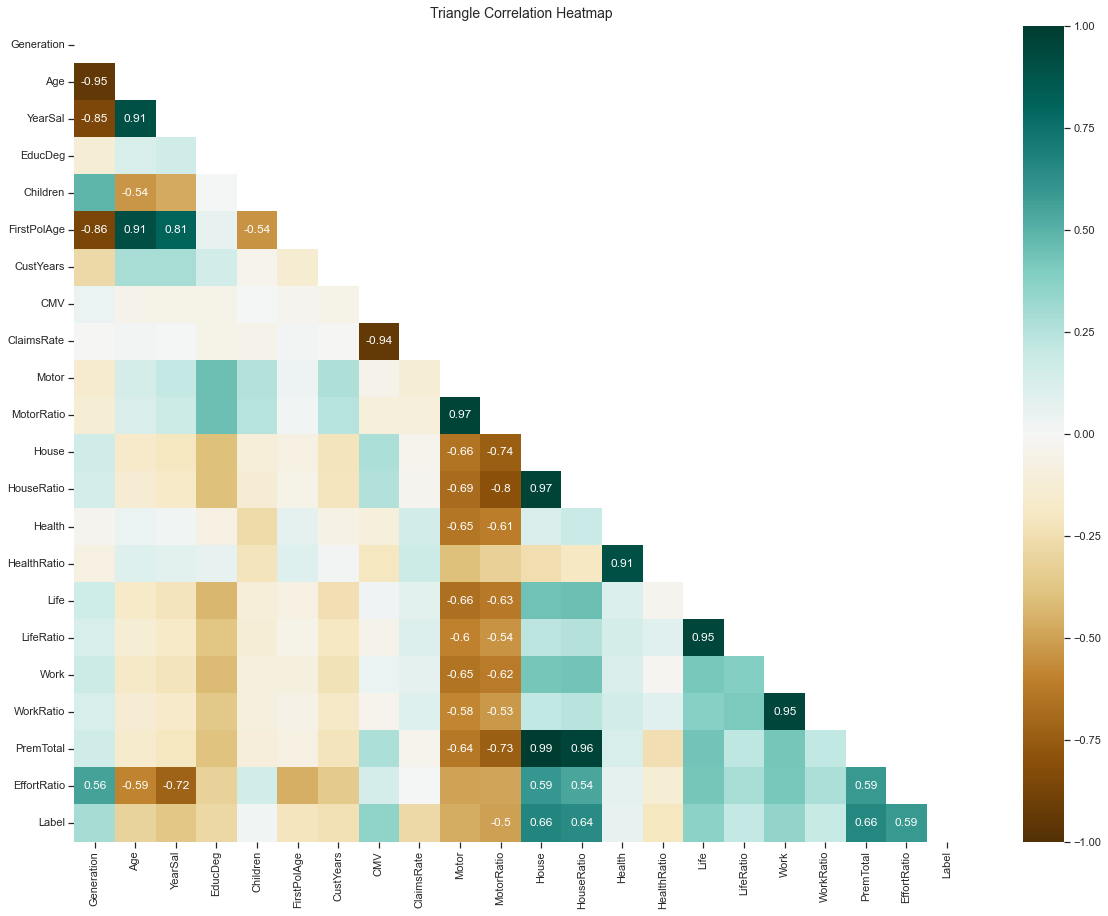

In [201]:
# correlation heatmap of features in the dataframe
# show value only for correlations higher than 0.4 or lower than -0.4
corr_heatmap(df, 0.5)

In [ ]:
# remove percetly redundant features from main dataframe
df.drop(columns = ["FirstPolYear", "BirthYear", "MonthSal"], inplace = True)

# TO BE DECIDED (based on future clustering) !!!!!!!!!!!!!!
# Age vs FirstPolAge vs Generation vs YearSal
# ClaimsRate vs CustMonVal
# PremTotal vs PremHousehold
# PremTotal vs PremHousehold_ratio
# Prem ratios vs Prem values

In [ ]:
# correlation heatmap after updating features
corr_heatmap(df, 0.5)

# update metric and non-metric features
metric_features = list(df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"]))
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

print("Metric features:", metric_features)
print("Non-metric features:", non_metric_features)

In [ ]:
# pairplot of current (metric) features
sns.pairplot(df[metric_features])

In [ ]:
# Correlation heatmap hinted at GeoLivArea having no meaningful correlation with any of the features
# visual representation of GeoLivArea and its relation with other features
sns.set(style = "ticks")

fig, axes = plt.subplots(6, 3, figsize=(20, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x = df["GeoLivArea"], y = df[feat], ax = ax)
    
plt.show()

# confirms that GeoLivArea appears to have no discriminative power

In [ ]:
# remove GeoLivArea from the main dataframe
df.drop(columns = "GeoLivArea", inplace = True)

# remove GeoLivArea from df_outliers
df_outliers.drop(columns = "GeoLivArea", inplace = True)

In [ ]:
# restructure and visualize the main dataframe before cluster analysis
df = restructure_df(df)
df.head()

In [ ]:
# restructure and visualize the outliers dataframe before cluster analysis
df_outliers = restructure_df(df_outliers)
df_outliers.head()

In [ ]:
# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "Children", "Generation"])
non_metric_features = ["EducDeg", "Children", "Generation"]

# compute total number of observations removed
nr_rows_removed = initial_len - len(df)
pc_rows_removed = round((nr_rows_removed / initial_len) * 100, 2)

print(
    f"Total number of observations removed: {nr_rows_removed} ({pc_rows_removed}%)\n"
    f"Final number of observations: {df.shape[0]} ({100 - pc_rows_removed}%)\n"
    f"Current number of features: {df.shape[1]}\n"
    "Features:",
    list(df.columns)
)

<a class="anchor" id="preprocessing-scaling"></a>

<h3><right>2.6. Feature skewness</right></h3>

In [ ]:
def transform_skewed_features(df, features, transformation):

    # create dataframe with the transformed features
    df_transformed = df.copy()

    for feat in features:
        # ensure all values are non-negative and apply square root transformation
        if transformation.lower() == "sqrt":
            df_transformed[feat] = np.sqrt(df_transformed[feat] + abs(df_transformed[feat].min()))

        # ensure all values are positive and apply log10 transformation
        if transformation.lower() == "log10":
            df_transformed[feat] = np.log10(df_transformed[feat] + abs(df_transformed[feat].min()) + 1)

    return df_transformed

In [ ]:
features = [
    "CMV",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# plot histogram of the potentially skewed metric features
plot_multiple(df, features, "histogram", [25, 15], nr_rows = 3)

In [ ]:
# list of skewed metric features
skewed_features = [
    "House",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# apply transformation to the skewed features  (could maybe apply log10 to PremTotal alone???????????????????????)
# save transformed features (and the others) in a copy of the original dataframe to preserve original values
df_transformed = transform_skewed_features(df, skewed_features, transformation = "sqrt")

# plot histogram of transformed features
plot_multiple(df_transformed, features, "histogram", [25, 15], nr_rows = 3)

In [ ]:
# At this point there are 3 important dataframes
#  df             - original, not transformed values (no square root transformation of skewed features)
#  df_transformed - identical to df except that square root transformation was applied to skewed metric features
#  df_outliers    - all of the outliers removed from df

<a class="anchor" id="data-clustering"></a>

***

<h2><center>3. CLUSTERING</center></h2>

***

In [ ]:
def data_scaler(df, scaler_name):

    '''
    Takes in a dataframe, df, and the name of the scaler,
    scaler_name, as arguments and applies the corresponding
    scaling method to the dataframe.

    Arguments:
     df (dataframe): dataframe without the target, y
     scaler_name (str): name of the scaler (minmax,
    standard, robust)

    Returns:
     df_scaled (dataframe): scaled version of the original df
    '''

    df_scaled = df.copy()
    features = list(df.columns)

    if scaler_name.lower() == "minmax":
        scaler = MinMaxScaler().fit(df)
        df_scaled[features] = scaler.transform(df)

    if scaler_name.lower() == "standard":
        scaler = StandardScaler().fit(df)
        df_scaled[features] = scaler.transform(df)

    if scaler_name.lower() == "robust":
        scaler = RobustScaler().fit(df)
        df_scaled[features] = scaler.transform(df)
    
    return (scaler, df_scaled)

In [ ]:
def kmeans_clustering(df, k):

    '''
    Takes in a dataframe, df, and a number of clusters, k,
    and assigns rows of the dataframe to clusters based on
    the KMeans algorithm.

    Arguments:
     df (dataframe): dataframe
     k (int): number of clusters

    Returns:
     centroids (ndarray): center of each cluster
     labels (ndarray): label of each row indicating the
    cluster it was assigned to
    '''
    
    clusters = KMeans(
        n_clusters = k,
        random_state = 15
    ).fit(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_

    return (centroids, labels)

In [ ]:
def kprototypes_clustering(df, k, cat_index, init = "Huang"):

    clusters = KPrototypes(
        n_clusters = k,
        init = init,
        random_state = 15
    ).fit(df, categorical = cat_index)
    labels = clusters.labels_
    centroids = clusters.cluster_centroids_

    return (centroids, labels)

In [ ]:
def hierarchical_clustering(df, n_clusters = None, threshold = 10000, affinity = "euclidean", linkage = "ward"):
    
    # determine clusters
    clusters = AgglomerativeClustering(
        n_clusters = n_clusters,
        affinity = affinity,
        linkage = linkage,
        distance_threshold = threshold
    ).fit(df)
    
    # retrieve cluster labels and distances
    labels = clusters.labels_
    distances = clusters.distances_
    
    counts = np.zeros(clusters.children_.shape[0])
    n_samples = len(labels)
    
    for i, merge in enumerate(clusters.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([clusters.children_, distances, counts]).astype(float)
    
    return (distances, labels, linkage_matrix)

In [ ]:
def db_scan(df, k):
    for eps in range(1,8):
        for min_samples in range(1,10):
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
            print(set(clustering.labels_))
            if len(set(clustering.labels_))==k+1:
                return (None, clustering.labels_)
            if len(set(clustering.labels_))==2 or len(set(clustering.labels_))==1:
                return None
    return (None)


In [ ]:
def plot_elbow(df, nmax_clusters, algorithm, cat_index = None, init = "Huang"):
    
    # store inertia values in a list
    y_vals = []
    
    # determine inertia for each number of clusters
    for n in np.arange(2, nmax_clusters + 1):
        if algorithm.lower() == "kmeans":
            km_clusters = KMeans(n_clusters = n, random_state = 15).fit(df)
            inertia = km_clusters.inertia_
            y_vals.append(inertia)

        if algorithm.lower() == "kprototypes":
            if type(cat_index) is int:
                cat_index = [cat_index]
            kp_clusters = KPrototypes(
                n_clusters = n,
                init = init,
                random_state = 15
            ).fit(df, categorical = cat_index)
            cost = kp_clusters.cost_
            y_vals.append(cost)
    
    # plot elbow graph
    sns.set_style("ticks")
    plt.subplots(figsize = (8, 6))
    sns.lineplot(x = np.arange(2, nmax_clusters + 1),
        y = y_vals,
        color = "k",
        marker = 'o',
        mew = 0,
        linewidth = 3)
    plt.title("Elbow plot", fontsize = 22)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim([0, nmax_clusters+1])
    plt.xlabel("Number of clusters, k", fontsize = 18)

    if algorithm.lower() == "kmeans":
        plt.ylabel("Inertia", fontsize = 18)
    elif algorithm.lower() == "kprototypes":
        plt.ylabel("Cost", fontsize = 18)

    return

In [ ]:
# Adapted from the following link and DM practical class:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

def plot_silhouette(df, nmax_clusters):

    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in np.arange(1, nmax_clusters + 1):
        # Skip nclus == 1
        if nclus == 1:
            continue
        
        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = metrics.silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        
        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
        
        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(df) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

    return

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [128]:
#takes in the results from one of the clustering algorithms and the data and presents the means
def summarise_clustering(df, labels, sort_by = None):

    df_temp = df.copy()
    df_temp["Cluster"] = labels

    # number of observations per cluster
    cluster_obs_num = pd.Series(df_temp.groupby("Cluster").size(), name = "obs")
    cluster_obs_pc = pd.Series(round(cluster_obs_num / df_temp.shape[0] * 100, 1), name = "%")
    cluster_size = pd.concat([cluster_obs_num, cluster_obs_pc], axis = 1)

    print("Cluster sizes:\n", cluster_size)

    # mean value of features for each cluster
    if sort_by == None:
        return df_temp.groupby("Cluster").mean()
    else:
        return df_temp.groupby("Cluster").mean().sort_values(sort_by)

In [139]:
def evaluate_clustering(df, labels):

    # cluster metrics
    ss = metrics.silhouette_score(df, labels, random_state = 15)
    dbs = metrics.davies_bouldin_score(df, labels)
    chs = metrics.calinski_harabasz_score(df, labels)

    print(
        f"Silhouette score: {round(ss, 2)}\n"
        f"Davies-Bouldin score: {round(dbs, 2)}\n"
        f"Calinski-Harabasz score: {round(chs, 2)}"
    )

    return

In [434]:
def visualize_clustering(df, labels, metric_features, categorical_features = None):

    temp_df = df.copy()
    temp_df["Label"] = labels

    for label in set(temp_df.Label):
        label_df = temp_df[temp_df.Label == label]

        fig, axes = plt.subplots(1, len(metric_features), figsize = [15, 4])

        for ax, feat in zip(axes.flatten(), metric_features):
            sns.histplot(
                data = label_df,
                x = feat,
                hue = "Label",
                alpha = 1,
                bins = 20,
                ax = ax
            )

            ax.set_xlim([temp_df[feat].min()*0.9, temp_df[feat].max()*1.1])

    return

<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>3.1. Sociodemographic clustering</right></h3>

In [ ]:
# dataframe with sociodemographic features - Generation, Age, YearSal, EducDeg, Children
# Age highly correlated with Generation and YearSal - using either produced very identical clusters with tested approaches, decided to use Age
df_sociodem = df[["Generation", "Age", "YearSal", "EducDeg", "Children"]]

#### 3.1.1. KMeans (Age, EducDeg)

In [368]:
# scaling dataframe
km_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, km_sociodem_minmax = data_scaler(km_sociodem, "minmax")
standard_scaler, km_sociodem_standard = data_scaler(km_sociodem, "standard")

# # choose number of clusters
# plot_elbow(km_sociodem, 15, "kmeans") 
# plot_silhouette(km_sociodem, 15)

# get cluster centroids and labels
km_sociodem_centroids, km_sociodem_labels = kmeans_clustering(km_sociodem_minmax, 4)

# cluster overview
df["Label"] = km_sociodem_labels
evaluate_clustering(km_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, "Age")

Silhouette score: 0.5
Davies-Bouldin score: 0.76
Calinski-Harabasz score: 10782.05
Cluster sizes:
           obs     %
Cluster            
0        2018  20.1
1        2595  25.8
2        2618  26.0
3        2820  28.1


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
1,3.461272,35.836994,19725.906918,1.692871,0.870135,9.935645,25.901349,231.597954,0.699981,219.318551,...,0.317330,175.682678,0.223922,66.233846,0.077391,64.290116,0.075073,836.857464,0.053424,1.0
3,3.334043,38.728723,23130.602073,3.124113,0.916667,10.241135,28.487589,210.504691,0.659957,357.957812,...,0.152558,156.004578,0.226665,24.158096,0.033107,24.370752,0.033228,689.193968,0.034132,3.0
0,1.797820,63.784936,40119.636559,1.816650,0.496531,33.939544,29.845391,217.834945,0.696506,267.376938,...,0.275082,173.767909,0.228292,49.497359,0.063109,47.855164,0.061348,785.090282,0.020024,0.0
2,1.737968,64.514515,40472.157366,3.129488,0.484339,34.682200,29.832315,204.108040,0.671524,342.586379,...,0.164531,168.700206,0.245120,25.592299,0.036081,25.227670,0.035614,692.348858,0.017541,2.0


#### 3.1.2. KMeans + Hierarchical (Age, EducDeg)

Silhouette score: 0.46830526705511366
Davies-Bouldin score: 0.8089540883073576
Calinski-Harabasz score: 9595.892376192522
Cluster sizes:
           obs     %
Cluster            
0        2923  29.1
1        2472  24.6
2        1690  16.8
3        2966  29.5


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
1,3.345874,37.483414,22204.337316,3.176780,0.914239,9.352346,28.131068,212.277152,0.660813,341.604709,...,0.162330,166.430368,0.240858,26.132880,0.035763,26.233426,0.035612,695.850190,0.035822,1.0
0,3.304482,37.918577,21400.196925,1.757783,0.873418,11.582278,26.336298,229.161153,0.696295,237.459264,...,0.301865,169.184465,0.217472,62.111037,0.073183,60.227027,0.070776,822.683862,0.049756,0.0
3,1.915374,62.526972,39209.468639,3.084963,0.537087,32.555293,29.971679,203.381308,0.669454,358.019329,...,0.154982,158.521301,0.231126,23.778149,0.033519,23.574690,0.033347,686.431096,0.018079,3.0
2,1.746154,65.608876,41181.881312,1.728402,0.418343,35.750296,29.858580,219.378438,0.702207,245.328325,...,0.293632,184.635503,0.240296,53.379846,0.067616,51.692882,0.066117,799.557621,0.019886,2.0


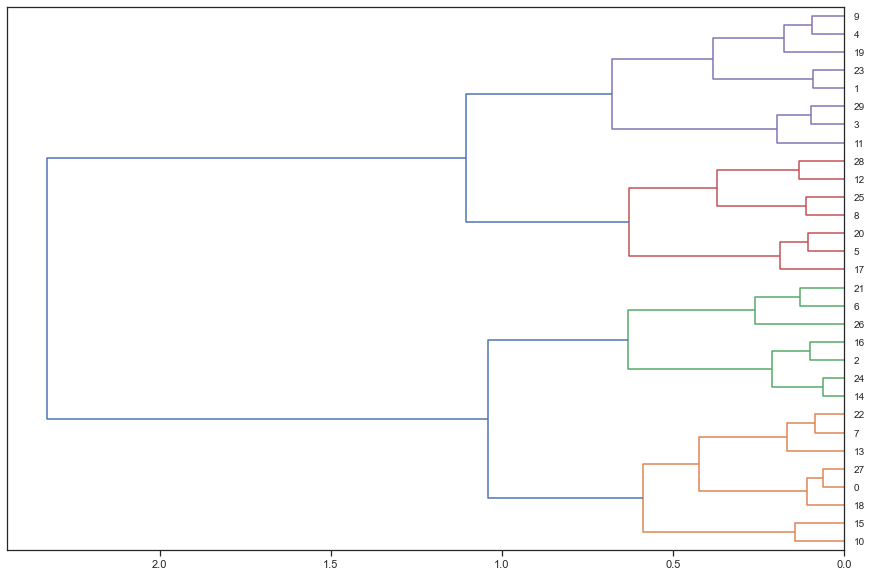

In [130]:
# scale data
km_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, km_sociodem_minmax = data_scaler(km_sociodem, "minmax")
standard_scaler, km_sociodem_standard = data_scaler(km_sociodem, "standard")

# get cluster centroids and labels
km_sociodem_centroids, km_sociodem_labels = kmeans_clustering(km_sociodem_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_sociodem_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_sociodem_linkage = hierarchy.linkage(km_sociodem_centroids, method = "ward")
hierarchy.dendrogram(
    km_sociodem_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_sociodem_centroids)
hc_sociodem_labels = pd.Series(hc_sociodem_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_sociodem_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_sociodem_centroids), columns = ["Age", "EducDeg"])
km_sociodem_centroids = pd.concat([km_sociodem_centroids, hc_sociodem_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_sociodem_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_sociodem_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, "Age")

#### 3.1.3. Hierarchical (Age, EducDeg)

Silhouette score: 0.45058158605000315
Davies-Bouldin score: 0.7603394288780212
Calinski-Harabasz score: 8960.491621366835
Cluster sizes:
           obs     %
Cluster            
0        3773  37.5
1        2608  25.9
2        2005  19.9
3        1665  16.6


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
1,3.458972,35.904908,19780.989437,1.708589,0.870015,10.002684,25.902224,231.500483,0.699390,221.052880,...,0.316254,174.856733,0.222848,65.921035,0.077027,63.937991,0.074637,835.986200,0.053271,1.0
0,2.972436,43.695468,26521.839882,3.182613,0.869070,14.847866,28.847601,213.538290,0.653522,367.912250,...,0.147177,149.766043,0.218663,23.079881,0.031938,23.110554,0.031801,684.883583,0.030276,0.0
2,1.790025,63.877805,40180.216746,1.797007,0.494264,34.007980,29.869825,217.872494,0.697252,265.432613,...,0.276209,174.829840,0.229718,49.795731,0.063491,48.206628,0.061826,785.887930,0.020006,2.0
3,1.643844,68.018619,42713.215588,3.000000,0.344745,38.232432,29.786186,193.572438,0.692727,311.230781,...,0.183578,190.103766,0.273818,28.856505,0.040433,28.573838,0.040213,703.922246,0.016784,3.0


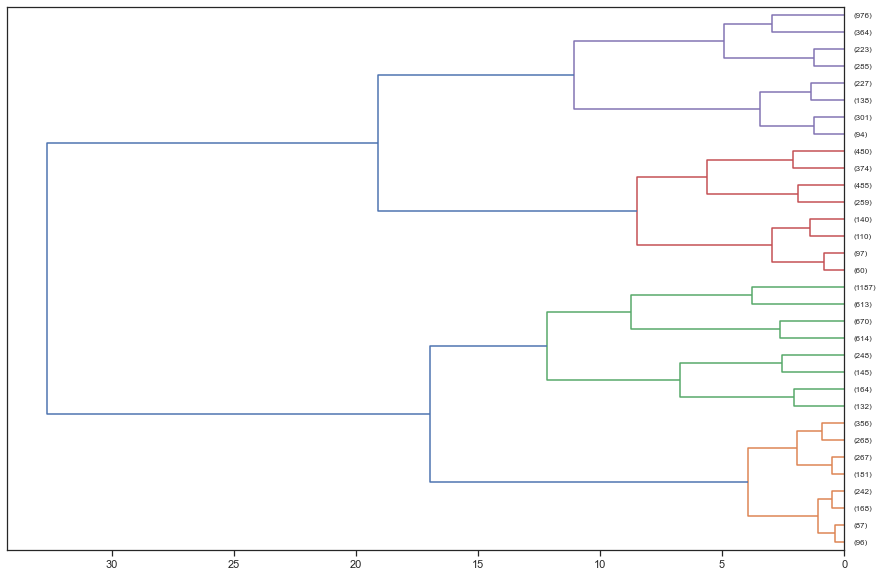

In [131]:
# scale data
hc_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, hc_sociodem_minmax = data_scaler(hc_sociodem, "minmax")
standard_scaler, hc_sociodem_standard = data_scaler(hc_sociodem, "standard")

# visualize dendrogram
hc_sociodem_distances, hc_sociodem_labels, hc_sociodem_linkage = hierarchical_clustering(
    hc_sociodem_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_sociodem_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 15
)

# perform AgglomerativeClustering
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(hc_sociodem_minmax)
hc_sociodem_labels = hc_sociodem_clusters.labels_

# overview of the clusters
df["Label"] = hc_sociodem_labels
evaluate_clustering(hc_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, "Age")

#### 3.1.4. DBSCAN (Age, EducDeg)

In [132]:
# scale data
db_sociodem = df_sociodem[["Age", "EducDeg"]]
minmax_scaler, db_sociodem_minmax = data_scaler(db_sociodem, "minmax")
standard_scaler, db_sociodem_standard = data_scaler(db_sociodem, "standard")

# find possible values for eps
for eps in np.arange(0.05, 0.41, 0.05):
    db_sociodem_clusters = DBSCAN(eps = eps).fit(db_sociodem_minmax)
    print(f"Clusters with eps = {round(eps, 2)}: {set(db_sociodem_clusters.labels_)}")

# get clusters and labels based on selected eps
db_sociodem_clusters = DBSCAN(eps = 0.2).fit(db_sociodem_minmax)
db_sociodem_labels = db_sociodem_clusters.labels_

# overview of the clusters
df["Label"] = db_sociodem_labels
evaluate_clustering(db_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, "Age")

Clusters with eps = 0.05: {0, 1, 2, 3, -1}
Clusters with eps = 0.1: {0, 1, 2, 3, -1}
Clusters with eps = 0.15: {0, 1, 2, 3}
Clusters with eps = 0.2: {0, 1, 2, 3}
Clusters with eps = 0.25: {0, 1, 2, 3}
Clusters with eps = 0.3: {0, 1, 2, 3}
Clusters with eps = 0.35: {0}
Clusters with eps = 0.4: {0}
Silhouette score: 0.42782955780743065
Davies-Bouldin score: 1.1253120121655096
Calinski-Harabasz score: 4931.55814530564
Cluster sizes:
           obs     %
Cluster            
0        3446  34.3
1        1167  11.6
2        4749  47.2
3         689   6.9


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
1,2.970865,43.780634,24775.382059,1.0,0.705227,18.253642,25.526992,253.753385,0.701277,177.027584,...,0.381169,165.656358,0.199311,84.610000,0.095344,82.176195,0.092119,899.024679,0.054294,1.0
0,2.653221,49.513349,29958.585074,2.0,0.707197,21.175566,28.337783,216.035232,0.697507,261.783839,...,0.270971,177.956825,0.234816,50.209701,0.062948,48.608517,0.061263,785.489121,0.033570,0.0
2,2.571910,51.039587,31402.987119,3.0,0.709413,21.943567,29.096020,207.424211,0.668970,343.616884,...,0.167035,164.685456,0.237684,26.245841,0.036237,26.162198,0.036089,697.052304,0.026538,2.0
3,2.522496,51.853411,32005.253991,4.0,0.702467,22.449927,29.403483,207.431785,0.641785,398.397083,...,0.098271,144.410479,0.220841,15.217663,0.022831,15.279071,0.022573,647.017286,0.023434,3.0


#### 3.1.5. KPrototypes (Age, EducDeg, Children)

In [133]:
# scale data
kp_sociodem = df_sociodem[["Age", "EducDeg", "Children"]]
minmax_scaler, kp_sociodem_minmax = data_scaler(kp_sociodem, "minmax")
standard_scaler, kp_sociodem_standard = data_scaler(kp_sociodem, "standard")

# # elbow plot
# # suggests 4-8 clusters
# plot_elbow(kp_sociodem_minmax, nmax_clusters = 15, algorithm = "kprototypes", cat_index = 2)

# compute centroids and labels with k = 4
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 4, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(df, df.Label, sort_by = "Age")

Silhouette score: 0.4191688506621158
Davies-Bouldin score: 1.0295862093904007
Calinski-Harabasz score: 7411.041050207255
Cluster sizes:
           obs     %
Cluster            
0        3458  34.4
1        3931  39.1
2        1155  11.5
3        1507  15.0


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.115674,41.175535,23797.347666,1.727588,0.911799,14.232794,26.942741,229.975654,0.692979,246.514025,...,0.296623,165.907169,0.214183,59.950376,0.071434,58.631457,0.069915,815.765130,0.045372,0.0
1,2.941745,44.408547,26955.867163,3.125413,0.955482,15.527092,28.881455,213.541348,0.653938,368.351936,...,0.149495,147.993070,0.215868,23.364785,0.032439,23.798553,0.032845,685.816446,0.029782,1.0
2,1.589610,68.683983,43167.901990,1.805195,0.092641,39.009524,29.674459,212.408485,0.714874,221.863896,...,0.305512,201.604502,0.260716,55.804416,0.070272,52.516874,0.066537,809.559732,0.019175,2.0
3,1.584605,68.708693,43278.627746,3.130060,0.064366,38.912409,29.796284,191.471161,0.695753,304.141148,...,0.181349,198.957724,0.286890,28.718978,0.040018,27.351991,0.038373,703.484970,0.016656,3.0


In [134]:
# compute centroids and labels with k = 6
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 6, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(df, df.Label, sort_by = "Age")

Silhouette score: 0.40099159273923746
Davies-Bouldin score: 1.1106822890230266
Calinski-Harabasz score: 6324.1858160545
Cluster sizes:
           obs     %
Cluster            
0        1044  10.4
1        1507  15.0
2        1085  10.8
3         859   8.5
4        3931  39.1
5        1625  16.2


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
5,3.468308,35.420308,19773.160233,2.000000,0.894769,8.836308,26.584000,216.001169,0.706855,230.682068,...,0.294254,189.436031,0.246355,57.198603,0.069587,55.304474,0.067701,809.009698,0.048652,5.0
3,3.431898,35.528522,18536.366792,1.000000,0.839348,11.407451,24.121071,269.291548,0.690198,167.810442,...,0.393601,158.525914,0.188257,90.147125,0.099009,88.388533,0.096338,917.867823,0.066430,3.0
4,2.941745,44.408547,26955.867163,3.125413,0.955482,15.527092,28.881455,213.541348,0.653938,368.351936,...,0.149495,147.993070,0.215868,23.364785,0.032439,23.798553,0.032845,685.816446,0.029782,4.0
2,2.174194,57.242396,36028.567538,1.905991,1.000000,27.252535,29.989862,214.620903,0.677733,339.109382,...,0.217099,135.567493,0.186709,37.859364,0.050355,38.679576,0.051343,738.104802,0.020940,2.0
0,1.596743,68.515326,43108.270879,1.802682,0.000000,38.837165,29.678161,215.900948,0.713736,212.411006,...,0.312998,206.381370,0.265471,57.759559,0.072244,53.296657,0.067183,816.115307,0.019349,0.0
1,1.584605,68.708693,43278.627746,3.130060,0.064366,38.912409,29.796284,191.471161,0.695753,304.141148,...,0.181349,198.957724,0.286890,28.718978,0.040018,27.351991,0.038373,703.484970,0.016656,1.0


In [135]:
# compute centroids and labels with k = 8
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 8, cat_index = 2, init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(df, df.Label, sort_by = "Age")

Silhouette score: 0.45343916642436627
Davies-Bouldin score: 1.0327478217076296
Calinski-Harabasz score: 6538.247218081851
Cluster sizes:
           obs     %
Cluster            
0         510   5.1
1        1508  15.0
2        1625  16.2
3        1407  14.0
4        1044  10.4
5        2013  20.0
6        1073  10.7
7         871   8.7


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
2,3.468308,35.420308,19773.160233,2.000000,0.894769,8.836308,26.584000,216.001169,0.706855,230.682068,...,0.294254,189.436031,0.246355,57.198603,0.069587,55.304474,0.067701,809.009698,0.048652,2.0
7,3.412170,35.824340,18790.290556,1.000000,0.841561,11.628014,24.196326,267.261768,0.692032,169.139805,...,0.392293,158.722583,0.188641,89.561091,0.098453,87.997187,0.096074,916.196326,0.065815,7.0
5,3.416791,36.338301,21393.183232,3.000000,0.925484,8.353701,27.984600,213.380015,0.666657,324.653706,...,0.180026,174.779896,0.250191,28.837784,0.039017,28.840378,0.038701,709.077114,0.037673,5.0
0,2.872549,45.511765,27761.411765,4.000000,0.945098,16.431373,29.080392,212.798196,0.627451,421.613588,...,0.083450,126.601294,0.195755,13.033412,0.019807,13.944176,0.020848,636.663549,0.026175,0.0
1,2.220822,56.665782,35311.196267,3.001326,1.000000,26.535809,30.129973,213.643223,0.645358,411.522732,...,0.128589,118.080398,0.175369,19.094317,0.027406,19.842155,0.028460,669.239503,0.019472,1.0
6,2.176142,57.245107,36018.072487,1.916123,1.000000,27.250699,29.994408,215.657148,0.676104,339.946021,...,0.216187,135.151090,0.186380,37.750308,0.050262,38.441323,0.051054,737.451230,0.020930,6.0
3,1.606254,68.444918,43150.194750,3.125800,0.000000,38.710732,29.734186,190.293568,0.699325,296.521002,...,0.186278,204.069808,0.293529,29.591144,0.041117,28.203539,0.039434,707.045124,0.016792,3.0
4,1.596743,68.515326,43108.270879,1.802682,0.000000,38.837165,29.678161,215.900948,0.713736,212.411006,...,0.312998,206.381370,0.265471,57.759559,0.072244,53.296657,0.067183,816.115307,0.019349,4.0


#### 3.1.6. KPrototypes + Hierarchical (Age, EducDeg, Children)

In [136]:
# compute centroids and labels
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 20, cat_index = 2, init = "Huang")

# add labels obtained with KPrototypes to main df
df["Label"] = kp_sociodem_labels

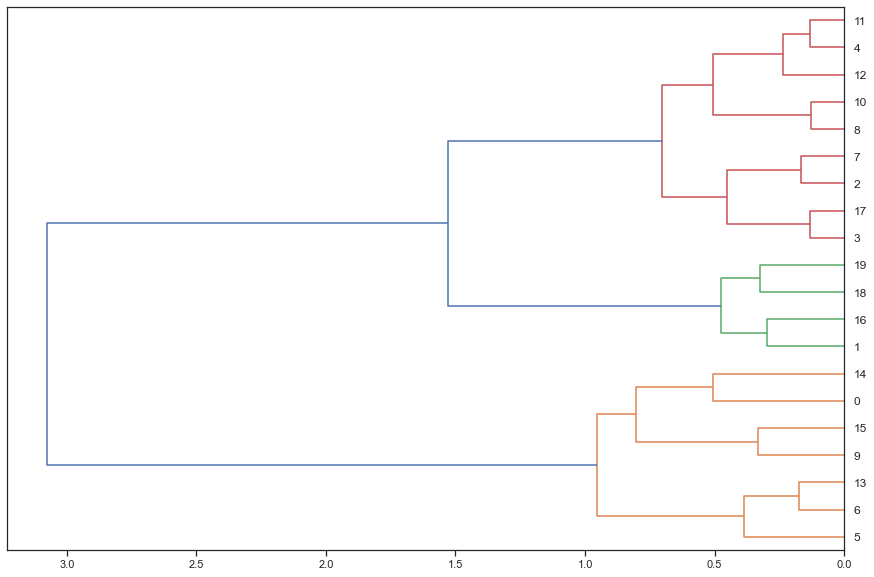

In [137]:
# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
kp_sociodem_linkage = hierarchy.linkage(kp_sociodem_centroids, method = "ward")
hierarchy.dendrogram(
    kp_sociodem_linkage,
    orientation = "left",
    color_threshold = 1.0
);

In [138]:
# hierarchical clustering of the centroids obtained
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(kp_sociodem_centroids)
hc_sociodem_labels = pd.Series(hc_sociodem_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
kp_sociodem_centroids = pd.DataFrame(minmax_scaler.inverse_transform(kp_sociodem_centroids), columns = ["Age", "EducDeg", "Children"])
kp_sociodem_centroids = pd.concat([kp_sociodem_centroids, hc_sociodem_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = kp_sociodem_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = kp_sociodem_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(kp_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, sort_by = "Age")

Silhouette score: 0.4930091871318817
Davies-Bouldin score: 0.8839512622183574
Calinski-Harabasz score: 17544.089125171464
Cluster sizes:
           obs     %
Cluster            
0        1546  15.4
1        3853  38.3
2        3260  32.4
3        1392  13.8


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
2,3.013497,43.016564,25298.519089,1.747546,1.0,15.553374,27.463190,223.529561,0.693816,260.574718,...,0.280985,164.918390,0.215894,54.950991,0.066657,54.508748,0.066172,799.539794,0.041555,2.0
1,2.875162,45.552297,27760.720949,3.125616,1.0,16.559304,28.992992,211.344724,0.653714,374.181485,...,0.142951,146.639022,0.215262,21.960161,0.030777,22.172045,0.030962,680.416766,0.028597,1.0
0,2.228978,57.198577,34691.383440,1.915265,0.0,29.239327,27.959250,233.047594,0.703952,200.847840,...,0.333109,194.779282,0.245873,66.171326,0.079772,62.109761,0.075008,841.424120,0.033855,0.0
3,1.590517,68.716236,43294.864952,3.132902,0.0,38.965517,29.750718,190.557845,0.698434,296.928786,...,0.185169,204.301272,0.294076,29.335754,0.040800,28.036659,0.039206,706.225855,0.016682,3.0


In [ ]:
# strip plot for cluster visualization?
# sns.set_style("ticks")

# # test = df.copy()
# # test.EducDeg = test.EducDeg.replace(educ_mapper)

# x_vars = ["Age", "EducDeg"]

# g = sns.PairGrid(df.sort_values("Age", ascending = False),
#                  x_vars = x_vars, y_vars = ["Cluster"],
#                  hue = "Children",
#                  height = 8,
#                  aspect = 0.85)

# g.map(sns.stripplot, size = 12, orient = "h", jitter = True,
#       palette = ["gray", "palevioletred"], alpha = 0.1)

# # add better labels
# g.set(ylabel = "Clusters")

# titles = ["Age", "EducDeg"]

# for ax, title in zip(g.axes.flat, titles):

#     # set axis titles
#     ax.set(title = title)

#     # horizontal grid
#     ax.xaxis.grid(False)
#     ax.yaxis.grid(True, lw = 1.5)
    
# plt.legend(title = "Children")

<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>3.2. Value clustering</right></h3>

In [87]:
# potentially relevant features for customer segmentation based on value
# CMV and ClaimsRate largely redundant - try both, choose one
# probably want to include PremTotal + CMV/ClaimsRate
# see if other features seem relevant
df_value = df_transformed[[
    "FirstPolAge",
    "CustYears",
    "CMV",
    "ClaimsRate",
    "PremTotal",
    "EffortRatio"
]]

,FirstPolAge,CustYears,CMV,ClaimsRate,PremTotal,EffortRatio
CustID,,,,,,
1,3.0,31.0,380.97,0.39,32.004843,0.182501
2,14.0,21.0,-131.13,1.12,35.632990,0.346355
3,21.0,25.0,504.67,0.28,33.156447,0.186907
4,9.0,26.0,-16.99,0.99,30.974667,0.231035
5,13.0,30.0,35.23,0.90,31.432308,0.193837


#### 3.2.1. KMeans (FirstPolAge, CustYears, CMV, PremTotal, EffortRatio)

In [436]:
# scale data
km_value = df_value[["FirstPolAge", "CustYears", "CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
# plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 8)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(km_value, df.Label)

Silhouette score: 0.22
Davies-Bouldin score: 1.36
Calinski-Harabasz score: 3107.4
Cluster sizes:
           obs     %
Cluster            
0        1639  16.3
1        1611  16.0
2        1455  14.5
3        1807  18.0
4        1216  12.1
5         617   6.1
6        1232  12.3
7         474   4.7


,FirstPolAge,CustYears,CMV,PremTotal,EffortRatio
Cluster,,,,,
0,32.497254,34.800488,197.118048,33.224650,0.160562
1,44.803849,23.555556,207.243880,33.259664,0.159517
2,25.364261,23.982131,192.831230,31.704951,0.171831
3,8.034311,25.407858,169.817266,32.772682,0.218716
4,10.827303,34.931743,439.160510,32.454559,0.183618
5,9.784441,21.113452,60.648266,37.363214,0.310421
6,10.298701,35.664773,-0.547549,31.850723,0.179306
7,10.959916,22.453586,745.623418,38.315688,0.289021


#### 3.2.2. KMeans (CMV, PremTotal, EffortRatio)

In [444]:
# scale data
km_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
# plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 4)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(df, df.Label, sort_by = "CMV")

Silhouette score: 0.37
Davies-Bouldin score: 1.03
Calinski-Harabasz score: 5795.39
Cluster sizes:
           obs     %
Cluster            
0        4119  41.0
1        3936  39.2
2         714   7.1
3        1282  12.8


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2.492353,52.298373,32526.051249,2.611556,0.703083,22.962127,29.336247,8.704064,0.951964,333.514171,...,0.134675,169.142484,0.254130,31.855523,0.047121,31.628495,0.046734,666.156514,0.023051,0.0
3,3.348674,37.721529,19016.807931,1.980499,0.745710,12.963339,24.758190,84.392894,0.879212,150.114446,...,0.471539,187.134095,0.201360,80.236771,0.083497,76.909922,0.080556,979.695156,0.067631,3.0
1,2.482470,52.482470,32666.501836,2.641514,0.707317,23.159299,29.323171,385.056039,0.397876,341.841781,...,0.173890,160.006900,0.229139,30.183237,0.041727,29.167706,0.040428,696.343196,0.023807,1.0
2,3.126050,41.291317,22975.989874,1.917367,0.668067,16.240896,25.050420,712.803067,0.317647,144.747381,...,0.554448,170.531204,0.162324,75.646092,0.070920,76.324580,0.070955,1080.362633,0.064236,2.0


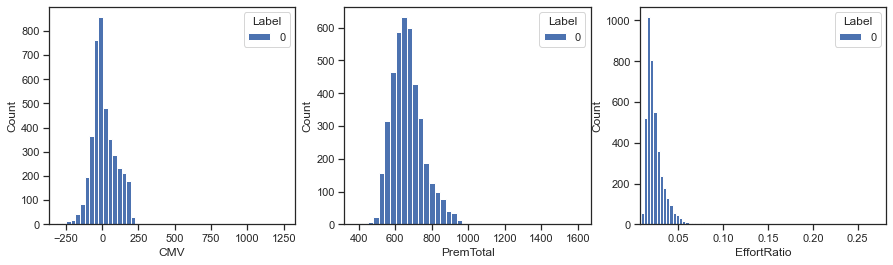

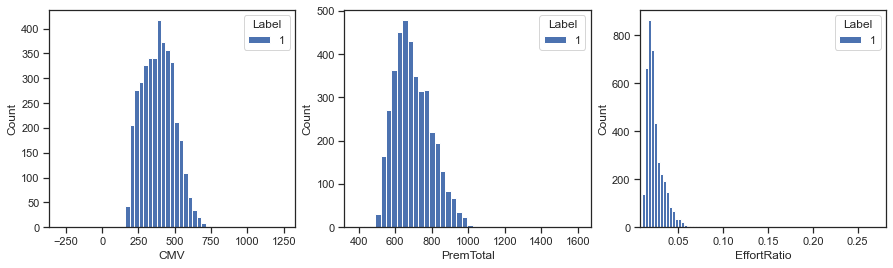

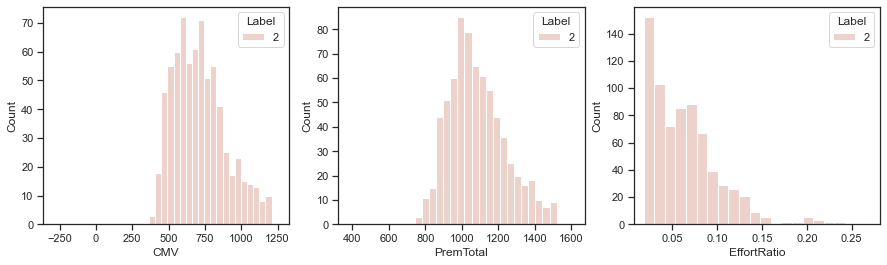

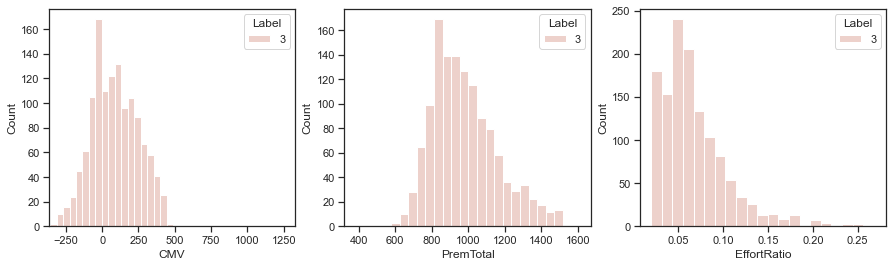

In [445]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.3. KMeans (ClaimsRate, PremTotal, EffortRatio)

In [255]:
# scale data
km_value = df_value[["ClaimsRate", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot (maybe 4-6 clusters)
# plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 5)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(df, df.Label, sort_by = "ClaimsRate")

Silhouette score: 0.37
Davies-Bouldin score: 1.04
Calinski-Harabasz score: 6441.42
Cluster sizes:
           obs     %
Cluster            
0        2283  22.7
1        2578  25.6
2         872   8.7
3         739   7.4
4        3579  35.6


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
1,2.518619,51.713732,32265.140713,2.750194,0.766874,22.237781,29.475950,433.913371,0.294166,388.998200,...,0.109066,136.939957,0.210651,21.929721,0.032930,22.004445,0.032947,650.097653,0.022196,1.0
3,3.286874,38.516915,20441.868430,1.920162,0.695535,13.917456,24.599459,683.943938,0.340244,140.564222,...,0.542269,174.552517,0.169705,77.868552,0.074441,78.199350,0.074072,1066.398173,0.069218,3.0
0,2.507665,52.195795,31919.124982,2.397722,0.615856,23.505475,28.690320,251.302777,0.646382,243.818962,...,0.291439,204.470394,0.267826,48.502335,0.062441,46.337157,0.059667,781.323745,0.028842,0.0
2,3.369266,37.352064,18561.704003,1.880734,0.735092,13.047018,24.305046,27.248303,0.948761,132.340436,...,0.514830,179.570298,0.182763,86.906124,0.086123,81.153028,0.080783,1036.178429,0.074435,2.0
4,2.508243,52.057279,32408.862561,2.637329,0.719475,22.715004,29.342274,-14.803663,0.985840,345.425147,...,0.123875,162.820204,0.246831,29.700006,0.044272,29.926287,0.044486,659.604334,0.022937,4.0


#### 3.2.4. KMeans (CMV, PremTotal)

Silhouette score: 0.46
Davies-Bouldin score: 0.73
Calinski-Harabasz score: 9051.4
Cluster sizes:
           obs     %
Cluster            
0        3975  39.5
1        3889  38.7
2         824   8.2
3        1363  13.6


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2.581635,50.809560,31233.606139,2.625912,0.725283,21.709182,29.100377,7.822475,0.952966,335.416606,...,0.122360,168.881811,0.256774,32.055165,0.048163,32.070523,0.048005,656.308382,0.024906,0.0
3,2.839325,46.406456,26943.602776,1.992663,0.628760,19.990462,26.415994,68.051988,0.902010,165.296192,...,0.489150,183.115649,0.191098,73.682810,0.074125,69.245444,0.070118,992.929861,0.052888,3.0
1,2.576241,50.853433,31172.172050,2.644896,0.732579,21.770892,29.082540,379.672576,0.399488,341.617223,...,0.164632,160.875963,0.232590,30.737699,0.043018,29.777889,0.041739,687.871849,0.026244,1.0
2,2.925971,44.708738,25762.462099,1.968447,0.635922,19.105583,25.603155,689.526505,0.327718,155.220109,...,0.541508,171.858968,0.166272,72.210085,0.068239,73.432100,0.068980,1061.566468,0.058333,2.0


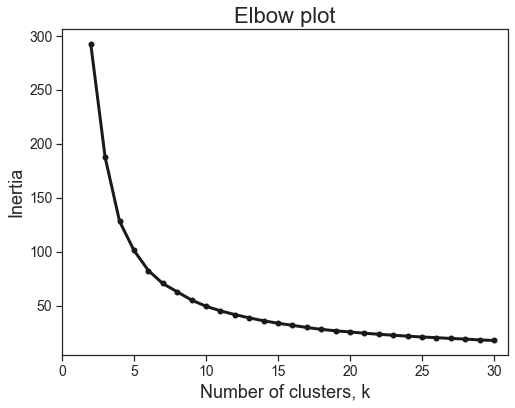

In [284]:
# scale data
km_value = df_value[["CMV", "PremTotal"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
# plot_elbow(km_value_minmax, 30, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 4)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(df, df.Label, sort_by = "CMV")

#### 3.2.5. KMeans + Hierarchical (CMV, PremTotal, EffortRatio)

Silhouette score: 0.52
Davies-Bouldin score: 0.77
Calinski-Harabasz score: 2793.18
Cluster sizes:
           obs     %
Cluster            
0        9320  92.7
1         415   4.1
2         316   3.1


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
2,3.746835,30.443038,10876.405063,1.680380,0.768987,9.389241,21.053797,4.015443,0.970222,92.947911,...,0.571515,160.731867,0.152478,103.646456,0.095087,98.374051,0.090843,1125.960570,0.115162,2.0
0,2.573605,50.927039,31317.642581,2.552361,0.708155,22.009979,28.917060,197.154009,0.687867,315.247968,...,0.193760,168.423439,0.237704,36.454672,0.048929,35.573914,0.047859,715.883506,0.026964,0.0
1,3.354217,37.515663,19318.525301,1.790361,0.650602,14.098795,23.416867,794.750482,0.297880,114.573181,...,0.609886,163.018120,0.142439,82.841325,0.072152,85.641084,0.074222,1166.785036,0.080772,1.0


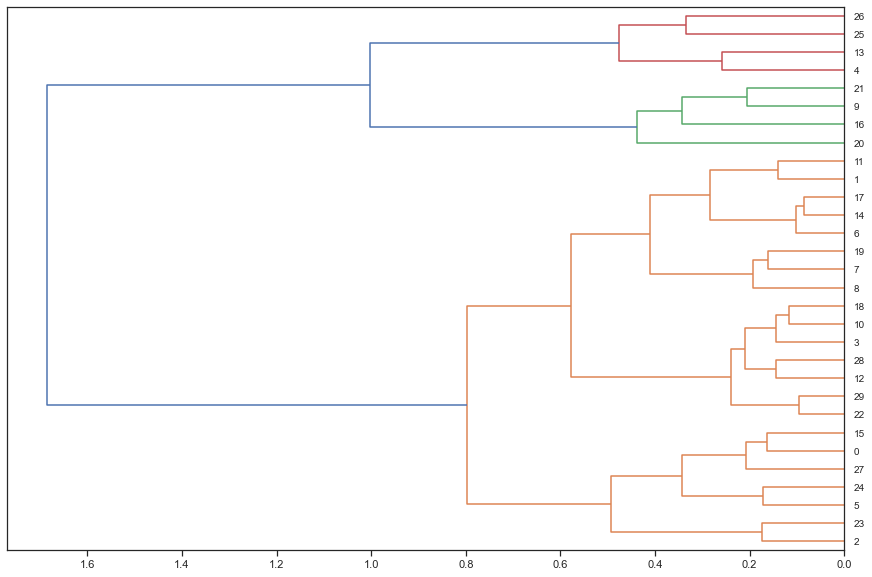

In [459]:
# scale data
km_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_value_centroids), columns = ["CMV", "PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(df, df.Label, "CMV")

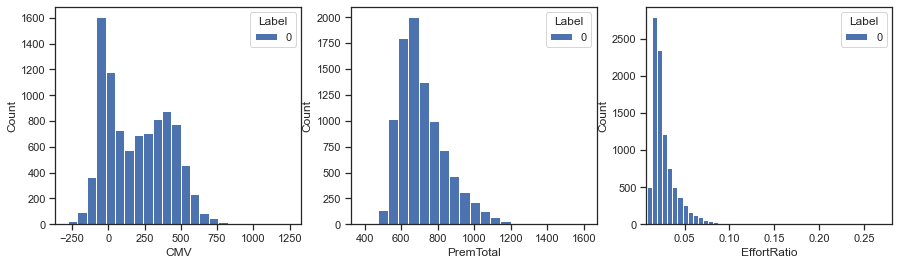

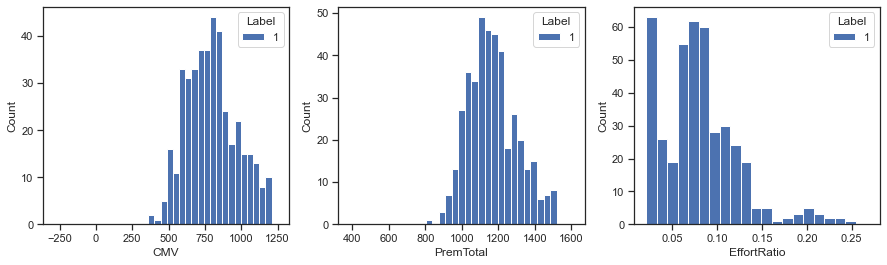

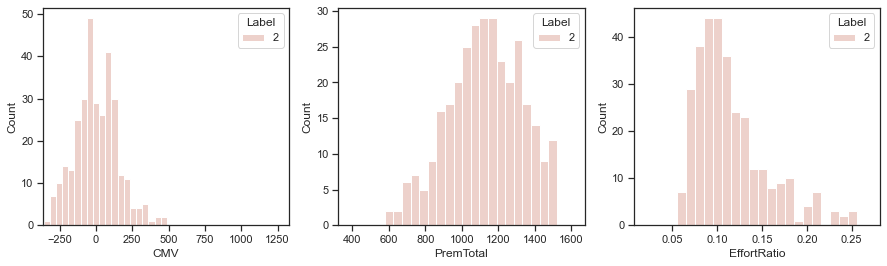

In [460]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.6. KMeans + Hierarchical (ClaimsRate, PremTotal, EffortRatio)

Silhouette score: 0.38
Davies-Bouldin score: 0.95
Calinski-Harabasz score: 5573.22
Cluster sizes:
           obs     %
Cluster            
0         684   6.8
1        4458  44.4
2        4909  48.8


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
2,2.529232,51.668161,32001.724964,2.569770,0.700754,22.550825,29.117336,378.818776,0.433545,317.351328,...,0.205023,167.589091,0.234041,35.133795,0.046995,34.068643,0.045653,723.822854,0.025574,2.0
0,3.748538,30.593567,12442.456140,1.701754,0.744152,9.217836,21.375731,393.259781,0.636871,95.078216,...,0.589737,162.320102,0.147639,97.539810,0.087658,97.446725,0.087677,1141.563947,0.102882,0.0
1,2.598026,50.530283,30894.448858,2.530956,0.709735,21.746074,28.784208,8.962456,0.959453,312.274406,...,0.186117,169.230247,0.240646,37.617752,0.050550,36.850516,0.049680,712.870677,0.028107,1.0


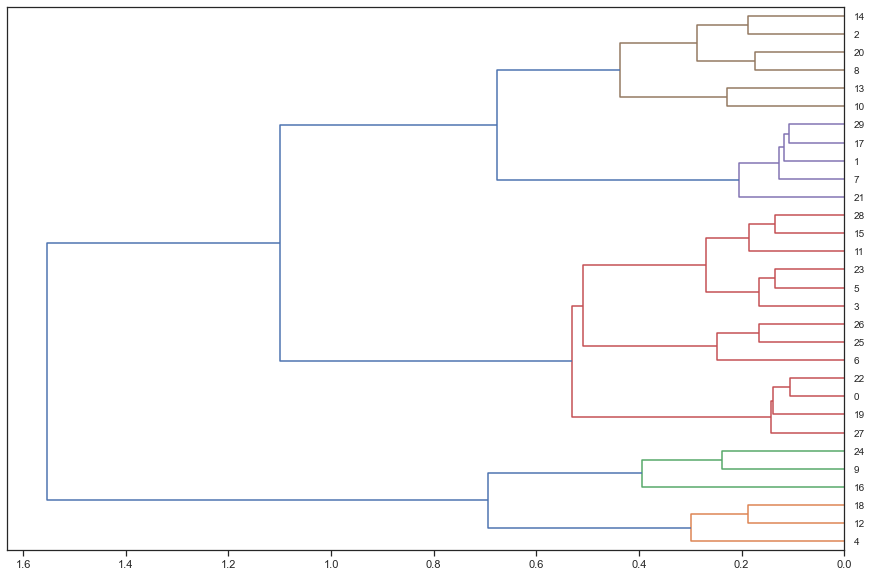

In [339]:
# scale data
km_value = df_value[["ClaimsRate", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 0.6
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_value_centroids), columns = ["ClaimsRate", "PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_minmax, df.Label)
summarise_clustering(df, df.Label, "ClaimsRate")

#### 3.2.7. Hierarchical

Silhouette score: 0.29
Davies-Bouldin score: 1.08
Calinski-Harabasz score: 4523.34
Cluster sizes:
           obs     %
Cluster            
0        5718  56.9
1        1516  15.1
2        2817  28.0


,CMV,PremTotal,EffortRatio
Cluster,,,
0,56.992921,32.888829,0.183646
2,393.666180,31.603711,0.172323
1,483.985844,37.085128,0.265542


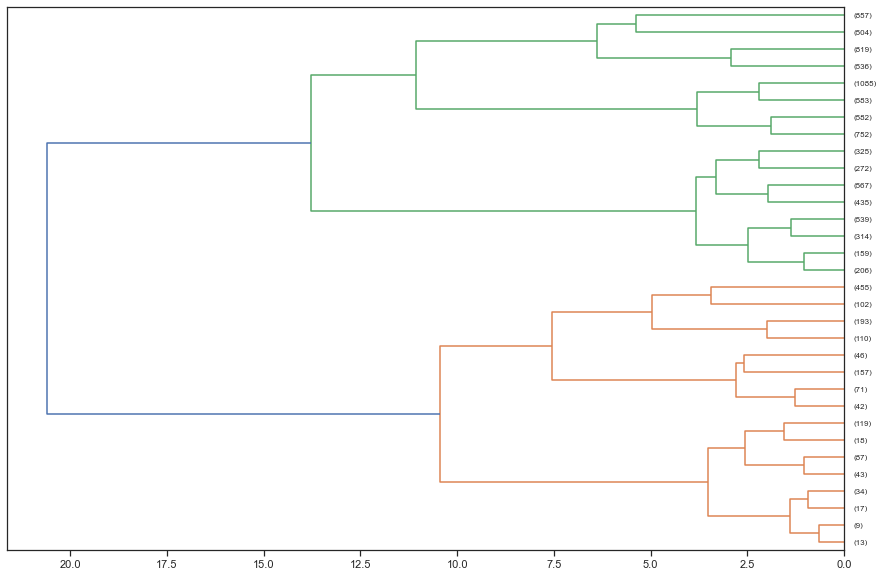

In [461]:
# scale data
hc_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, hc_value_minmax = data_scaler(hc_value, "minmax")
standard_scaler, hc_value_standard = data_scaler(hc_value, "standard")
robust_scaler, hc_value_robust = data_scaler(hc_value, "robust")

hc_value_distances, hc_value_labels, hc_value_linkage = hierarchical_clustering(
    hc_value_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_value_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 15
)

# perform AgglomerativeClustering
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(hc_value_minmax)
hc_value_labels = hc_value_clusters.labels_

# overview of the clusters
df["Label"] = hc_value_labels
evaluate_clustering(hc_value_minmax, df.Label)
summarise_clustering(hc_value, df.Label, "CMV")

#### 3.2.8. DBSCAN

In [488]:
# scale data
db_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, db_value_minmax = data_scaler(db_value, "minmax")
standard_scaler, db_value_standard = data_scaler(db_value, "standard")
robust_scaler, db_value_robust = data_scaler(db_value, "robust")

# find possible values for eps
for eps in np.arange(0.05, 0.1, 0.01):
    db_value_clusters = DBSCAN(eps = eps).fit(db_value_minmax)
    print(f"Clusters with eps = {round(eps, 2)}: {set(db_value_clusters.labels_)}")

# get clusters and labels based on selected eps
db_value_clusters = DBSCAN(eps = 0.07).fit(db_value_minmax)
db_value_labels = db_value_clusters.labels_

# overview of the clusters
df["Label"] = db_value_labels
evaluate_clustering(db_value_minmax, df.Label)
summarise_clustering(db_value, df.Label, "CMV")

Clusters with eps = 0.05: {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Clusters with eps = 0.06: {0, 1, 2, 3, 4, 5, -1}
Clusters with eps = 0.07: {0, 1, 2, 3, -1}
Clusters with eps = 0.08: {0, 1, 2, -1}
Clusters with eps = 0.09: {0, 1, -1}
Silhouette score: 0.29
Davies-Bouldin score: 1.43
Calinski-Harabasz score: 211.6
Cluster sizes:
           obs     %
Cluster            
-1        145   1.4
 0       9889  98.4
 1          5   0.0
 2          7   0.1
 3          5   0.0


,CMV,PremTotal,EffortRatio
Cluster,,,
1,-373.754000,34.201716,0.259252
2,99.958571,34.720453,0.380855
3,143.768000,33.181662,0.423179
0,214.663770,33.090430,0.189834
-1,318.661310,37.902133,0.377521


#### 3.2.9. BIRCH

In [570]:
# scale data
birch_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, birch_value_minmax = data_scaler(birch_value, "minmax")
standard_scaler, birch_value_standard = data_scaler(birch_value, "standard")
robust_scaler, birch_value_robust = data_scaler(birch_value, "robust")

# model and labels
birch_value_clusters = Birch(threshold = 0.1).fit(birch_value_minmax)
birch_value_labels = birch_value_clusters.labels_
set(birch_value_labels)

# overview of the clusters
df["Label"] = birch_value_labels
evaluate_clustering(birch_value_minmax, df.Label)
summarise_clustering(df, df.Label, "CMV")

Silhouette score: 0.47
Davies-Bouldin score: 0.96
Calinski-Harabasz score: 2819.16
Cluster sizes:
           obs     %
Cluster            
0         665   6.6
1        9010  89.6
2         376   3.7


,Generation,Age,YearSal,EducDeg,Children,FirstPolAge,CustYears,CMV,ClaimsRate,Motor,...,HouseRatio,Health,HealthRatio,Life,LifeRatio,Work,WorkRatio,PremTotal,EffortRatio,Label
Cluster,,,,,,,,,,,,,,,,,,,,,
2,3.765957,30.545213,9791.840426,1.752660,0.771277,9.156915,21.388298,80.266303,0.887872,111.539654,...,0.476794,175.528085,0.193725,101.400824,0.103958,94.183245,0.097358,1018.507261,0.112583,2.0
1,2.578246,50.846615,31313.966799,2.562375,0.712098,21.920089,28.926526,182.828127,0.700802,318.218057,...,0.188079,167.866027,0.238109,35.669008,0.048066,34.828069,0.047033,711.627974,0.026626,1.0
0,2.881203,45.437594,26336.824060,1.978947,0.612030,19.560902,25.876692,738.502466,0.290316,159.318602,...,0.549888,164.930496,0.157127,71.254887,0.065926,73.627564,0.067935,1078.686962,0.058626,0.0


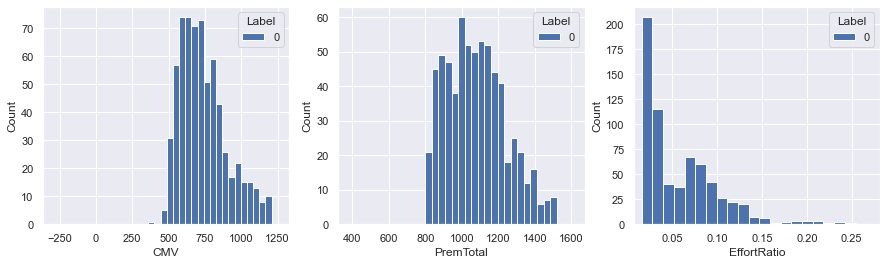

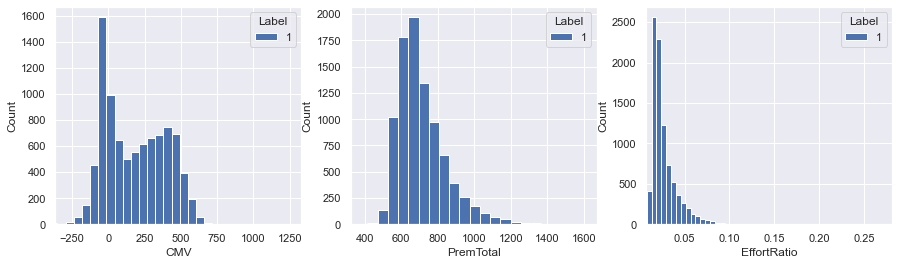

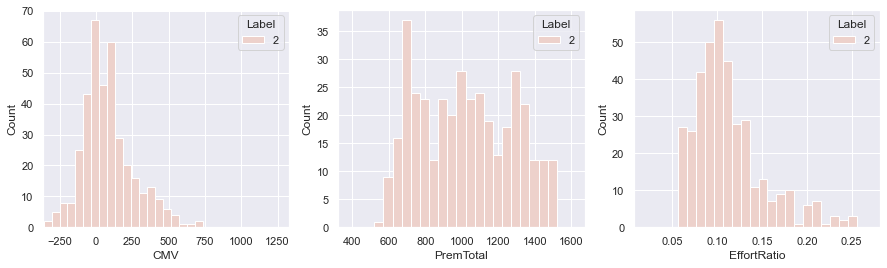

In [571]:
visualize_clustering(df, df.Label, ["CMV", "PremTotal", "EffortRatio"])

#### 3.2.10. SOM

In [590]:
import sompy
from sompy.visualization.mapview import View2D, View2DPacked
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# scale data
som_value = df_value[["CMV", "PremTotal", "EffortRatio"]]
minmax_scaler, som_value_minmax = data_scaler(som_value, "minmax")
standard_scaler, som_value_standard = data_scaler(som_value, "standard")
robust_scaler, som_value_robust = data_scaler(som_value, "robust")

X = som_value_minmax.values

np.random.seed(15)

sm = sompy.SOMFactory().build(
    X, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='seq',
    lattice='hexa',
    component_names=["CMV", "PremTotal", "EffortRatio"]
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.208000, quantization error: 0.272477

 epoch: 2 ---> elapsed time:  0.226000, quantization error: 1.482620

 epoch: 3 ---> elapsed time:  0.231000, quantization error: 1.445308

 epoch: 4 ---> elapsed time:  0.230000, quantization error: 1.441089

 epoch: 5 ---> elapsed time:  0.251000, quantization error: 1.439835

 epoch: 6 ---> elapsed time:  0.283000, quantization error: 1.438682

 epoch: 7 ---> elapsed time:  0.250000, quantization error: 1.437504

 epoch: 8 ---> elapsed time:  0.260000, quantization error: 1.435861

 epoch: 9 ---> elapsed time:  0.250000, quantization error: 1.433802

 epoch: 10 ---> elapsed time:  0.261000, quantization error: 1.432581

 epoch: 11 ---> elapsed time:  0.256000, quantization error: 1.431566

 epoch: 12 ---> elapsed time:  0.251000, quantization error: 1.430513

 epoch: 13 --->

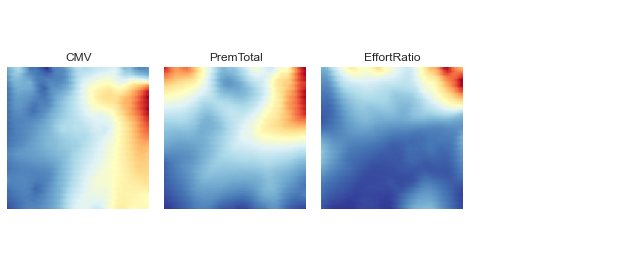

In [591]:
# Visualizing the Component planes (feature values)
sns.set()
view2D  = View2DPacked(10,10,"", text_size=7)
view2D.show(sm, col_sz=4, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

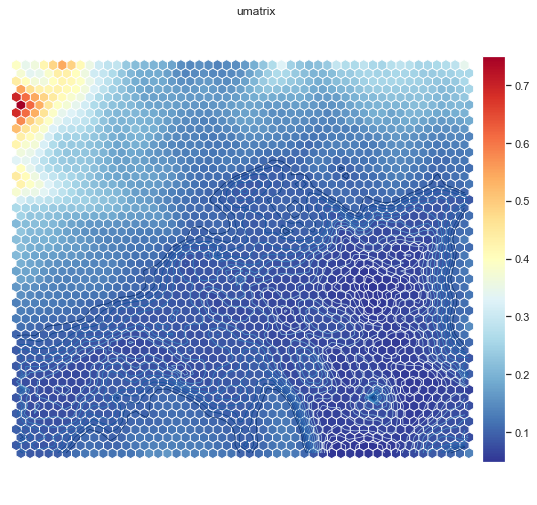

In [592]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True # Visualize isomorphic curves
)

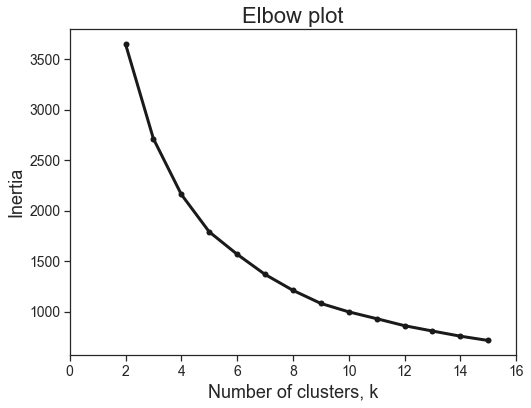

In [593]:
plot_elbow(sm.codebook.matrix, 15, "kmeans")

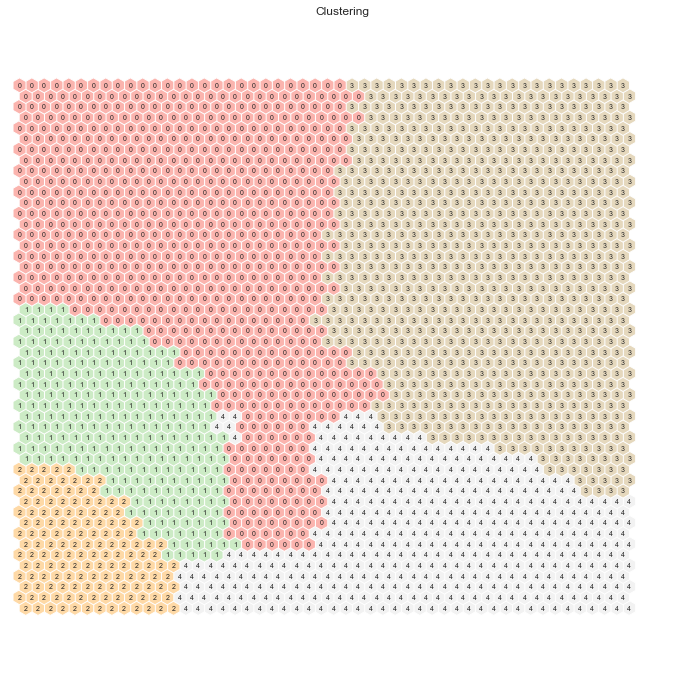

In [595]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=20, random_state=15)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

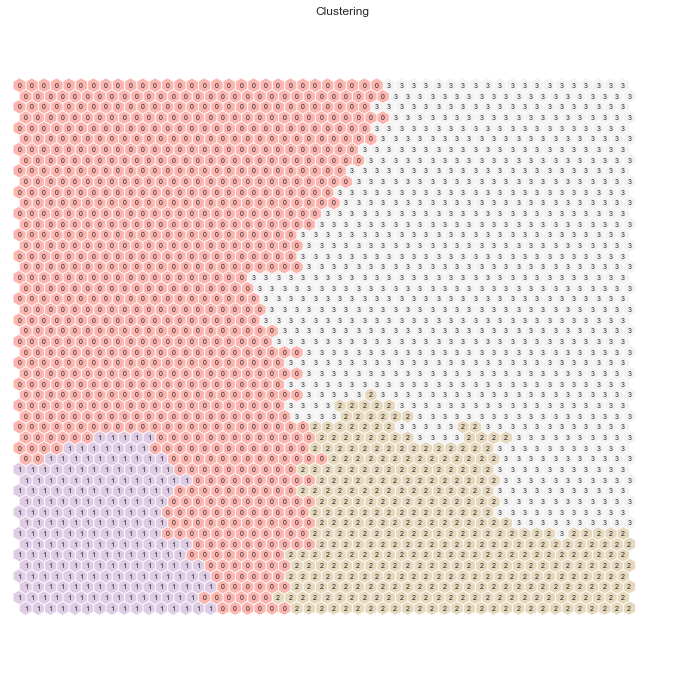

In [596]:
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

<a class="anchor" id="clustering-product"></a>

<h3><right>Product clustering</right></h3>

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [ ]:
# potentially relevant features to perform customer segmentation based on product
df_product = df_transformed[[
    "Motor", "MotorRatio",
    "House", "HouseRatio",
    "Health", "HealthRatio",
    "Life", "LifeRatio",
    "Work", "WorkRatio"
]]

# data scaling
df_product_minmax = data_scaler(df_product, "minmax")
df_product_standard = data_scaler(df_product, "standard")
df_product_robust = data_scaler(df_product, "robust")
scaled_data_sets=[(df_product_minmax,"minmax"),(df_product_robust,"robust"),(df_product_standard,"standard")]

In [ ]:
# try clustering approaches using the values or using the ratios, choose one of the two
# possible good approaches: Agglomerative Clustering, KMeans, DBScan, Self Organizing Maps, others?
# try different scaling methods: standard/robust better to deal with outliers than minmax

In [ ]:
#create sets of parameter combinations to try
df_product_values=["Motor","House","Health","Life","Work"]
df_product_ratios=["MotorRatio","HouseRatio","HealthRatio","LifeRatio","WorkRatio"]
df_product_all=["Motor", "MotorRatio","House", "HouseRatio","Health", "HealthRatio","Life", "LifeRatio","Work", "WorkRatio"]
df_product_object=["Motor","MotorRatio","House","HouseRatio"]
df_product_nonobject=["Health", "HealthRatio","Life", "LifeRatio","Work", "WorkRatio"]
combinations=[df_product_values,df_product_ratios,df_product_all,df_product_object,df_product_nonobject]

In [ ]:
df.head()

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
for combination in combinations:
    for scaled_data,scaler_name in scaled_data_sets:
        for algorithm in [kmeans_clustering,hierarchical_clustering]:
            print(combination,scaler_name,algorithm.__name__)
            data=scaled_data[combination]
            if algorithm.__name__=="hierarchical_clustering":
                labels=algorithm(data)[1]
            elif algorithm.__name__=="kmeans_clustering":
                labels=algorithm(data,k=4)[1]
            elif algorithm.__name__=="db_scan":
                labels=algorithm(data,k=4)
                if labels is None:
                    continue
                labels=labels[1]
            results=summarise_clustering(labels)
            if not results.shape[0]==1:
                print(metrics.silhouette_score(X=data,labels=labels))
                display(results) #[sum([combination+["YearSal","Age"]],[])]

In [ ]:
from sklearn.manifold import MDS


embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(df[:500])


In [ ]:
sns.scatterplot(x=X_transformed[:,0],y=X_transformed[:,1])

In [ ]:
df_product_standard[df_product_ratios][:100].reset_index().columns.get_loc(11)

In [ ]:
som_test=df_product_standard[df_product_ratios]

In [ ]:
som_test.shape

In [ ]:
from sklearn_som.som import SOM
som = SOM(m=3, n=2, dim=5)
som.fit(X=som_test.to_numpy(),shuffle=True)

In [ ]:
predictions=som.predict(X=som_test.to_numpy())

In [ ]:
predictions

In [ ]:
metrics.silhouette_score(som_test,predictions)

In [ ]:
df["Cluster"]=predictions
df.groupby("Cluster").size()

In [ ]:
df.groupby("Cluster").mean()